#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Dropout, Embedding, BatchNormalization, concatenate, dot, LSTM, Activation
from keras.utils import plot_model
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


#### Loading the Data

In [2]:
prices_d = pd.read_csv(r'C:\Users\Manan Arora\Desktop\AgriTech Project\Data Driven Business Metrics Project\Data\Prices and Arrival\Prices_Arrival_2013-18-002.csv')

C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Filtering for Onion in Sirsa, Haryana

In [3]:
onion_d = prices_d[prices_d['Commodity']=='Onion']
onion_d_sirsa = onion_d[(onion_d['LGD_State_Name']=='HARYANA') & (onion_d['Market Center']=='Sirsa')]
onion_d_sirsa.replace(-999.0,np.nan,inplace=True)
onion_d_sirsa.dropna(inplace=True)
print(len(onion_d_sirsa))

1608


C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Exploratory Data Analysis

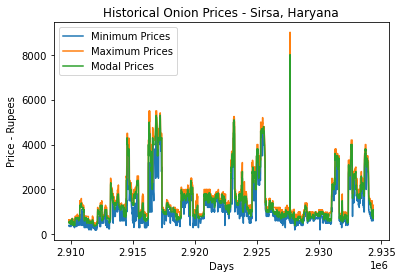

In [4]:
plt.figure()
plt.plot(onion_d_sirsa["Minimum Prices"])
plt.plot(onion_d_sirsa["Maximum Prices"])
plt.plot(onion_d_sirsa["Modal Prices"])
plt.title('Historical Onion Prices - Sirsa, Haryana')
plt.ylabel('Price - Rupees')
plt.xlabel('Days')
plt.legend(['Minimum Prices','Maximum Prices','Modal Prices'], loc='upper left')
plt.show()

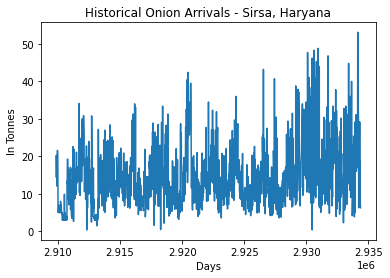

In [5]:
plt.figure()
plt.plot(onion_d_sirsa["Arrivals"])
plt.title('Historical Onion Arrivals - Sirsa, Haryana')
plt.ylabel('In Tonnes')
plt.xlabel('Days')
plt.show()

#### Splitting the Data into Test and Train

In [6]:
train_cols = ["Modal Prices"]

#### Scaling the Data

In [7]:
# scale the feature MinMax, build array
x = onion_d_sirsa.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)

#### Function1: Buidling Time Series

In [8]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm.tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

#### Function2: Trimming Data as required

In [9]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

#### Implementing the Functions

In [10]:
TIME_STEPS = 15
BATCH_SIZE = 1
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (1593, 15, 1) (1593,)


#### Creating the Model

In [11]:
model1 = Sequential()
model1.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
model1.add(Dropout(0.5))
model1.add(Dense(20,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))
optimizer = RMSprop(lr=0.001)
model1.compile(loss='mean_squared_error', optimizer=optimizer)

In [12]:
csv_logger = CSVLogger('lstm_infy_model.log')
your_epochs = 100
history1 = model1.fit(x_t, y_t, epochs=your_epochs, verbose=0, batch_size=BATCH_SIZE,
                    shuffle=False, callbacks=[csv_logger])

#### Checking the Error

In [13]:
val_error = np.amin(history1.history['loss']) 
print('Best validation error of epoch:', val_error)

Best validation error of epoch: 0.002106291976480755


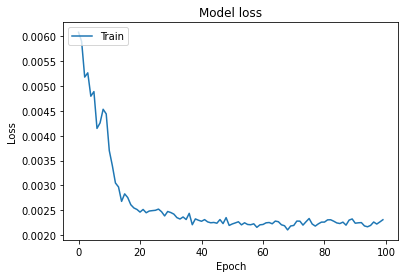

In [14]:
plt.figure()
plt.plot(history1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Predicting the Train Data

In [15]:
y_pred = model1.predict(trim_dataset(x_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_t, BATCH_SIZE)
error = mean_squared_error(y_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)


Error is 0.0024699333672313166 (1593,) (1593,)


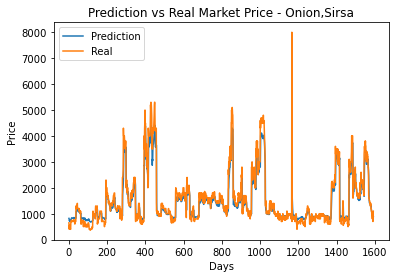

In [16]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Market Price - Onion,Sirsa')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

##### Predicting on Another Markets Data

In [17]:
onion_d_rania = onion_d[(onion_d['LGD_State_Name']=='HARYANA') & (onion_d['Market Center']=='Rania')]
onion_d_rania.replace(-999.0,np.nan,inplace=True)
onion_d_rania.dropna(inplace=True)
print(len(onion_d_rania))

1631


C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
x = onion_d_rania.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)

In [19]:
TIME_STEPS = 15
BATCH_SIZE = 1
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

C:\Users\Manan Arora\anaconda3\envs\manan\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (1616, 15, 1) (1616,)


In [20]:
y_pred = model1.predict(trim_dataset(x_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_t, BATCH_SIZE)
error = mean_squared_error(y_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)

Error is 0.004274528553429949 (1616,) (1616,)


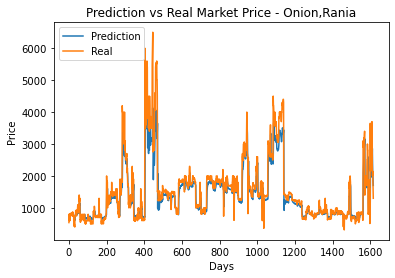

In [21]:
plt.figure()
plt.plot(y_pred_org)0
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Market Price - Onion,Rania')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 100)                  40800     
_________________________________________________________________
dropout_1 (Dropout)          (1, 100)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   2020      
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
